## Brute-Force Matching with ORB Descriptors

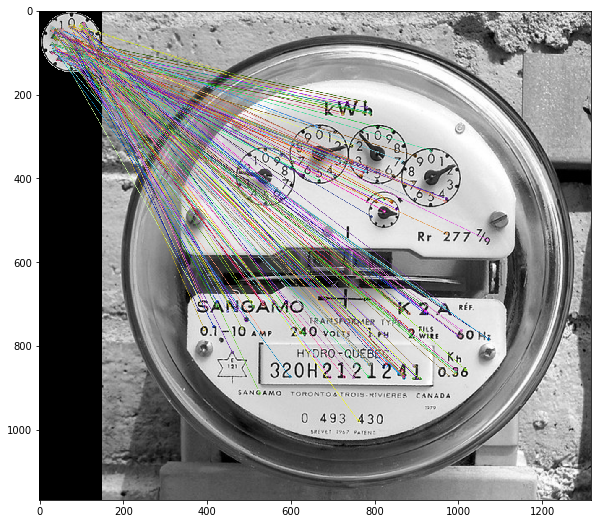

(<matplotlib.image.AxesImage at 0x121d6bfd0>, None)

In [36]:
import numpy as np
import cv2

%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] =(12,9)

img1 = cv2.imread('gauges/gauge_rot_314.png',0)          # queryImage
img2 = cv2.imread('original_gauge.png',0) # trainImage


# Initiate ORB detector
orb = cv2.ORB_create()

# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors.
matches = bf.match(des1,des2)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# Draw first 10 matches.
img3 = cv2.drawMatches(img1,kp1,img2,kp2,matches ,None, flags=2)

plt.imshow(img3),plt.show()

## FLANN based Matcher

FLANN stands for Fast Library for Approximate Nearest Neighbors. It contains a collection of algorithms optimized for fast nearest neighbor search in large datasets and for high dimensional features. It works more faster than BFMatcher for large datasets. We will see the second example with FLANN based matcher.

For FLANN based matcher, we need to pass two dictionaries which specifies the algorithm to be used, its related parameters etc. First one is IndexParams. For various algorithms, the information to be passed is explained in FLANN docs. As a summary, for algorithms like SIFT, SURF etc. you can pass following:



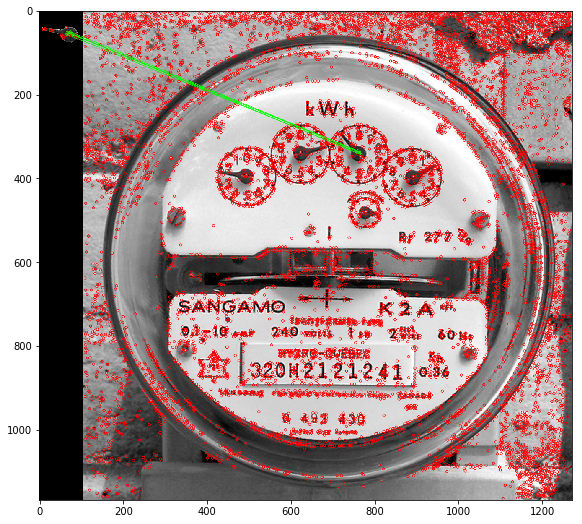

(<matplotlib.image.AxesImage at 0x11937f7d0>, None)

In [26]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

img1 = cv2.imread('needles/needle_rot_283.png',0)          
img2 = cv2.imread('original_gauge.png',0) 

# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary

flann = cv2.FlannBasedMatcher(index_params,search_params)

matches = flann.knnMatch(des1,des2,k=2)

# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in xrange(len(matches))]

# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        matchesMask[i]=[1,0]

draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = 0)

img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,**draw_params)

plt.imshow(img3,),plt.show()

## Feature Matching + Homography to find Objects

So what we did in last session? We used a queryImage, found some feature points in it, we took another trainImage, found the features in that image too and we found the best matches among them. In short, we found locations of some parts of an object in another cluttered image. This information is sufficient to find the object exactly on the trainImage.

For that, we can use a function from calib3d module, ie cv2.findHomography(). If we pass the set of points from both the images, it will find the perpective transformation of that object. Then we can use cv2.perspectiveTransform() to find the object. It needs atleast four correct points to find the transformation.

We have seen that there can be some possible errors while matching which may affect the result. To solve this problem, algorithm uses RANSAC or LEAST_MEDIAN (which can be decided by the flags). So good matches which provide correct estimation are called inliers and remaining are called outliers. cv2.findHomography() returns a mask which specifies the inlier and outlier points.

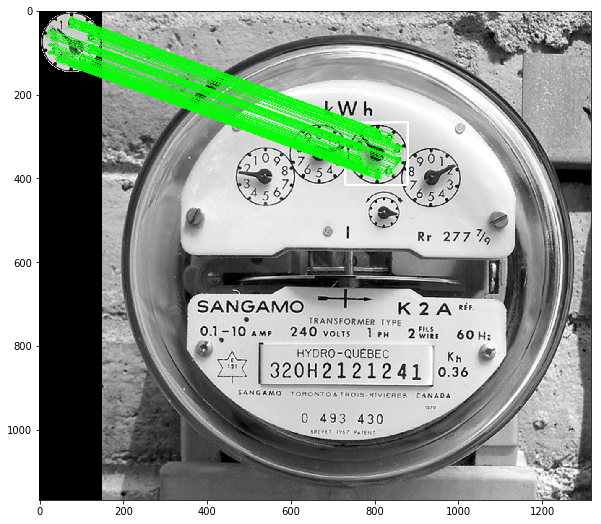

(<matplotlib.image.AxesImage at 0x121f1b610>, None)

In [34]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

MIN_MATCH_COUNT = 10

img1 = cv2.imread('gauges/gauge_rot_314.png',0)          
img2 = cv2.imread('original_gauge.png',0) 

# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)

flann = cv2.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(des1,des2,k=2)

# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)
        
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()

    h,w = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)

    img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)

else:
    print "Not enough matches are found - %d/%d" % (len(good),MIN_MATCH_COUNT)
    matchesMask = None

draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)

img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)

plt.imshow(img3, 'gray'),plt.show()